In [1]:
%pip install -U finance-datareader

In [4]:
import FinanceDataReader as fdr

fdr.StockListing('krx')
df = fdr.DataReader('005930', '2017-01-01', '2020-12-31')

In [35]:
# 데이터 정규화

raw_data = (df['Close'] - df['Close'].mean()) / df['Close'].std()

In [ ]:
raw_data

In [37]:
X = raw_data.to_numpy()

In [38]:
import numpy as np

In [39]:
# 주가 예측

# 1. 데이터 가공 (input sequence 길이를 얼마로 잡을것인가? - 5일, 7일, 15일, 30일)
X_data = np.array([[X[i+j] for j in range(5)] for i in range(len(X) - 6)]) # 5일씩 잘라서 입력으로 사용
y_data = np.array([X[i+5] for i in range(len(X) - 6)]) # 5일 뒤 값을 y (target으로 잡음)

train_idx = int(len(X_data) * 0.7) # 70% 데이터까지의 인덱스

X_train = X_data[:train_idx]
y_train = y_data[:train_idx]
X_test = X_data[train_idx:]
y_test = y_data[train_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# 데이터셋, 데이터로더 정의

# 2. 모델링 (어떤 모델을 사용할 것인가?)



# 3. 예측 (시각화)


(682, 5) (293, 5)
(682,) (293,)


In [40]:
# 데이터셋, 데이터로더 정의
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x.reshape(-1, 5, 1))
        self.y = torch.Tensor(y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [41]:
# 2. 모델링

import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, num_layers=1, batch_first=True)
        self.fc = nn.Linear(8, 1)
        return

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])

        return output

model = StockLSTM()
device = torch.device('cpu')
model.to(device)

StockLSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [42]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.5)
criterion = nn.MSELoss()


In [ ]:
for epoch in range(5):
    model.train()

    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)

        # print(data.shape)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

In [44]:
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
for data, label in test_loader:
    with torch.no_grad():
        output = model(data)
        y_pred = torch.cat([y_pred, output])
        y_real = torch.cat([y_real, label])

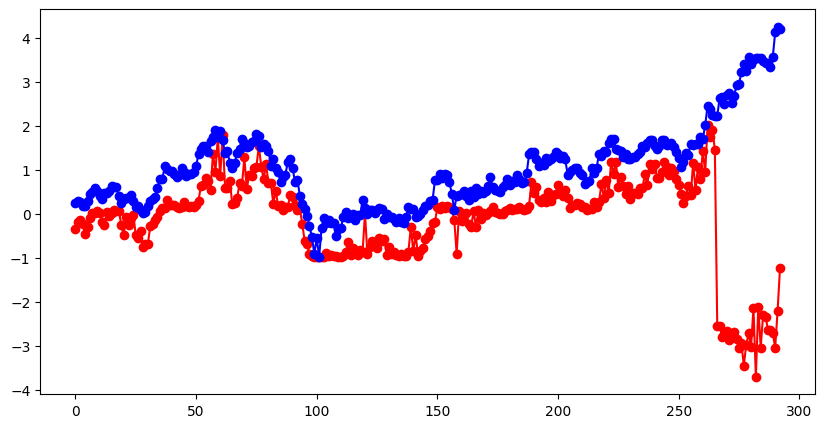

In [45]:
import matplotlib.pyplot as plt

x_axis = np.arange(0, len(y_pred))

plt.figure(figsize=(10, 5))

plt.plot(x_axis, y_pred, '-o', c='red')
plt.plot(x_axis, y_real, '-o', c='blue')
plt.show()